# Dino v2

In [1]:
import sys
import torch

In [2]:
BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")

backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()
backbone_model.to("cpu")

Using cache found in /home/eric/.cache/torch/hub/facebookresearch_dinov2_main
/home/eric/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/eric/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/eric/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [3]:
model = backbone_model

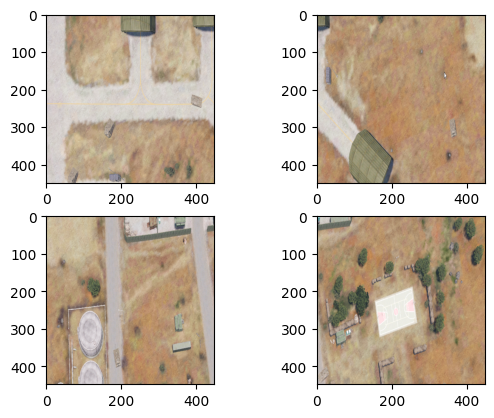

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import torchvision.transforms as tt

images = []

for i in range(1,5):
    #/disk3/eric/dataset/VISION_SOFS/WEAPON_4/train_mask/M2A1Slammer2__part_1.png
    image = cv2.imread(f"/disk3/eric/dataset/VISION_SOFS/WEAPON_4/train_mask/M2A1Slammer2__part_{i}.png")
    #image = cv2.imread(f"/disk3/eric/dataset/VISION_SOFS/WEAPON_4/test/z{i}.jpg")
    image = cv2.resize(image, (448,448))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float32')/255
    images.append(image)
    plt.subplot(220+i)
    plt.imshow(image)

# We need to reorder the images to [batch, channel, widht, height]
# The array of loaded images is [batch, height, width, channel]
images_arr = np.stack(images)
input_tensor = torch.Tensor(np.transpose(images_arr, [0, 3, 2, 1]))

transform = tt.Compose([tt.Normalize(mean=0.5, std=0.2)])

input_tensor = transform(input_tensor)

In [5]:
result = model.forward_features(input_tensor)

In [6]:
patch_tokens = result['x_norm_patchtokens'].detach().numpy().reshape([4,1024,-1])

In [8]:
patch_tokens.shape

(4, 1024, 1024)

In [9]:
all_patches = patch_tokens.reshape([-1,1024])

In [11]:
all_patches.shape

(4096, 1024)

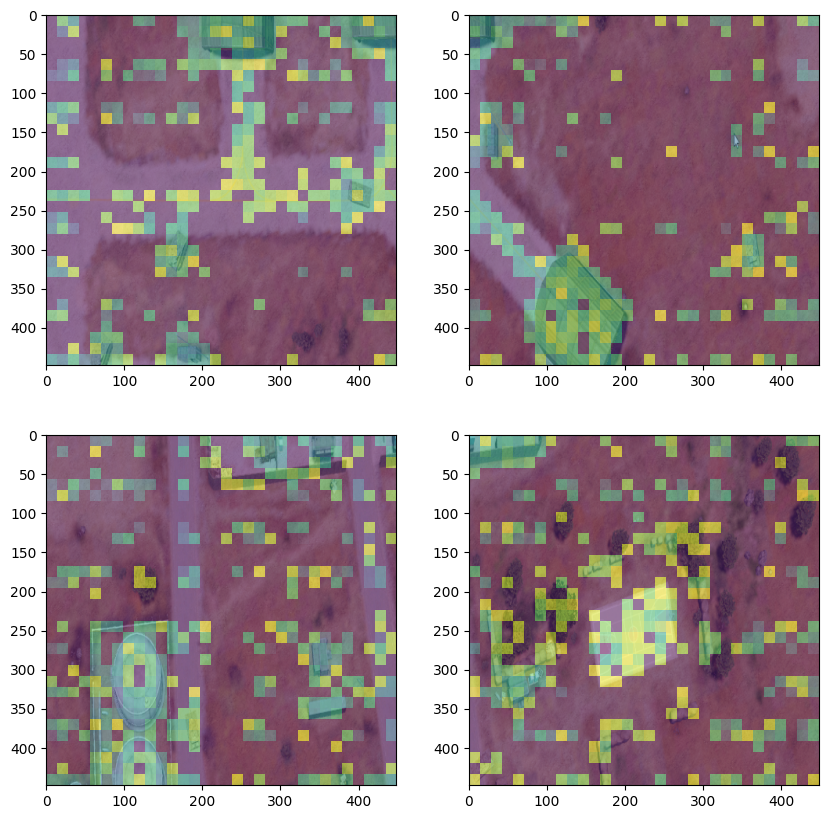

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale

fg_pca = PCA(n_components=1)

masks=[]
plt.figure(figsize=(10,10))

all_patches = patch_tokens.reshape([-1,1024])
reduced_patches = fg_pca.fit_transform(all_patches)
# scale the feature to (0,1)
norm_patches = minmax_scale(reduced_patches)

# reshape the feature value to the original image size
image_norm_patches = norm_patches.reshape([4,1024])

for i in range(4):
    image_patches = image_norm_patches[i,:]

    # choose a threshold to segment the foreground
    mask = (image_patches < 0.2).ravel()
    masks.append(mask)

    image_patches[np.logical_not(mask)] = 0

    plt.subplot(221+i)
    plt.imshow(images[i])
    plt.imshow(image_patches.reshape([32,-1]).T, extent=(0,448,448,0), alpha=0.5)